# Evaluating the Relationship Between ESG Performance and Stock Market Returns

**Course:** DATA 512 — Human-Centered Data Science  
**Author:** Ayush Mall  
**Date:** December 2024  
**Repository:** [esg-stock-performace-impact](https://github.com/ayushmall0710/esg-stock-performace-impact)

This notebook is the single, main deliverable containing the full written report and key code cells. It integrates narrative, data provenance, methods, findings, and reproducibility steps.


# Abstract
This study evaluates whether stronger Environmental, Social, and Governance (ESG) profiles for S&P 500 firms during September 2023–August 2024 are associated with superior risk-adjusted performance and lower risk. Using ESG scores from Sustainalytics (via Kaggle/Yahoo Finance), daily stock prices, and FRED risk-free rates, we construct a firm-level analysis dataset of 419 companies and estimate cross-sectional OLS models of Sharpe ratio and volatility, controlling for firm size and sector effects.

**Key Findings**
- **RQ1 (Risk-Adjusted Returns):** No statistically significant relationship between ESG scores and Sharpe ratios (coef = -0.0043, p = 0.535, R² = 0.204).
- **RQ2 (Volatility):** Higher ESG scores are associated with slightly **higher** volatility (coef = +0.0016, p = 0.018, R² = 0.149), contrary to de-risking claims.
- **RQ3 (Pillars):** Governance is the only significant pillar driving the volatility relationship (+0.0063, p = 0.013); Environmental and Social pillars show no significant effects.

ESG scores alone do not deliver near-term risk-adjusted performance premia in this window and may correlate with marginally higher risk, underscoring the need for deeper factor controls, longer horizons, and transparent evaluation of ESG investment claims.


# Introduction
## Motivation
ESG investing is expected to exceed $53T by 2025 (Bloomberg Intelligence, 2021). Asset managers often market ESG as delivering both impact and superior returns, yet empirical evidence is mixed and sometimes opaque. This project provides a transparent, reproducible test of those claims for S&P 500 firms.

## Research Objectives
1. Test whether higher ESG scores relate to superior risk-adjusted returns.  
2. Test whether higher ESG scores reduce stock return volatility.  
3. Identify which ESG pillar (E, S, G) drives any observed effects.

## Scope
- Universe: S&P 500 constituents (as of Sept 2023)
- Window: Sept 2023 – Aug 2024 (~12 months)
- Design: Cross-sectional firm-level regressions

## Why This Matters
- **Investors:** Need evidence on risk/return claims.  
- **Companies:** Need realistic expectations about ESG impacts on stock performance.  
- **Researchers/Policymakers:** Benefit from transparent, reproducible pipelines and documented limitations.


# Background & Related Work
- **Meta-analyses:** NYU Stern & Rockefeller (2021) reviewed 1,000+ studies; ~58% positive, 13% negative, 29% mixed/neutral ESG–performance findings.
- **Rating disagreement:** CFA Institute highlights large divergences across ESG vendors (e.g., Sustainalytics, MSCI, Refinitiv).
- **Data quality:** ESG scores rely on self-reported corporate data; methodology differences drive variance.
- **Contribution here:** Recent window (2023–24), full reproducibility, risk-adjusted focus (Sharpe), and pillar decomposition (E, S, G).


# Research Questions
1. **RQ1:** Do companies with higher ESG scores earn higher risk-adjusted returns over the following 12 months?  
2. **RQ2:** Do higher ESG scores reduce stock return volatility?  
3. **RQ3:** Which ESG pillar (E, S, G) drives risk-adjusted returns and volatility the most?


# Data & Licensing
- **S&P 500 ESG & prices (2023–24):** Kaggle dataset by R. Zala — GPL-3; underlying prices/metadata from Yahoo Finance via `yfinance`, for academic/research use. ESG scores from Sustainalytics as exposed in `yfinance` (`data/raw/sp500_esg_data.csv`, `sp500_price_data.csv`).
- **Risk-free rate:** FRED DGS3MO — Public Domain (`data/raw/DGS3MO.csv`).
- **Market & metadata:** Yahoo Finance via `yfinance` — academic/research use (`data/raw/sp500_index.csv`, `company_info.csv`).
- **Docs:** See `data/README.md` for full provenance, transformations, and licensing.
- **Final analysis dataset:** `data/final/analysis_dataset.csv` (419 firms, 33 variables) used for all regressions.


In [106]:
# Quick data check
import pandas as pd
from pathlib import Path

analysis_path = Path('../data/final/analysis_dataset.csv')
if analysis_path.exists():
    df = pd.read_csv(analysis_path)
    display(df.head())
    print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
else:
    print("analysis_dataset.csv not found. Please run the pipeline or place the file in data/final/.")


,Ticker,environmentScore,socialScore,governanceScore,totalEsg,ratingYear,ratingMonth,Trading_Days,Mean_Daily_Excess_Return,Annualized_Excess_Return,Sharpe_Ratio,Cumulative_Return,Annualized_Return,Mean_Daily_Return,Volatility,Beta,Downside_Deviation,Excess_Return_Std,VaR_5pct,Max_Drawdown,Market_Cap_Billions,Log_Market_Cap,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Unknown,Sector_Utilities
0,A,1.12,6.42,6.10,13.64,2023.0,9.0,250,0.000575,0.144821,0.526943,0.172340,0.173832,0.000786,0.274830,0.909428,0.194684,0.274832,-0.024378,-0.188955,43.517313,3.773159,0,0,0,0,0,1,0,0,0,0,0
1,AAL,9.94,11.65,4.76,26.35,2023.0,9.0,250,-0.001182,-0.297876,-0.739090,-0.276567,-0.278438,-0.000971,0.403028,1.501904,0.291972,0.403031,-0.036407,-0.409439,9.274215,2.227238,0,0,0,0,0,0,1,0,0,0,0
2,AAPL,0.46,7.39,9.37,17.22,2023.0,9.0,250,0.000646,0.162807,0.726335,0.208698,0.210533,0.000857,0.224149,1.007151,0.143515,0.224149,-0.021706,-0.167129,4138.242671,8.328027,0,0,0,0,0,0,0,0,1,0,0
3,ABBV,2.38,17.19,10.36,29.93,2023.0,9.0,250,0.000986,0.248576,1.300788,0.324629,0.327611,0.001198,0.191092,0.301399,0.149716,0.191097,-0.018746,-0.149973,402.433475,5.997530,0,0,0,0,0,1,0,0,0,0,0
4,ABT,2.27,14.24,8.33,24.83,2023.0,9.0,250,0.000245,0.061825,0.327600,0.101313,0.102163,0.000457,0.188718,0.239371,0.130817,0.188721,-0.017079,-0.172702,224.345162,5.413186,0,0,0,0,0,1,0,0,0,0,0


Rows: 426, Columns: 33


# Methodology
## Design
Cross-sectional OLS regressions at the firm level (one observation per company) using ESG scores measured at Sept 2023 to explain realized outcomes over Sept 2023–Aug 2024.

## Models
- **Model 1 (RQ1):** $\text{Sharpe\_Ratio} \sim \text{totalEsg} + \log(\text{Market Cap}) + \text{Sector dummies}$
- **Model 2 (RQ2):** $\text{Volatility} \sim \text{totalEsg} + \log(\text{Market Cap}) + \text{Sector dummies}$
- **Model 3a (RQ3):** $\text{Sharpe\_Ratio} \sim \text{environmentScore} + \text{socialScore} + \text{governanceScore} + \text{controls}$
- **Model 3b (RQ3):** $\text{Volatility} \sim \text{environmentScore} + \text{socialScore} + \text{governanceScore} + \text{controls}$

## Controls
- **Size:** Log market cap
- **Industry:** 11 sector dummies

## Diagnostics
- Heteroskedasticity: Breusch-Pagan (HC3 robust SE if needed)
- Multicollinearity: VIF
- Residual normality: Jarque-Bera (not binding with n>400)

## Rationale
- Standard cross-sectional design in finance for factor effects
- Risk-adjusted focus via Sharpe ratio; volatility for risk
- Transparent, reproducible pipeline (scripts + notebooks)


## 6. Findings

This section presents detailed results for each research question, including regression analysis, visualizations, and interpretations.


## Research Question 1: ESG and Risk-Adjusted Returns

**Question:** Do companies with higher ESG scores earn higher risk-adjusted returns over the following 12 months?

**Hypothesis:** Higher ESG scores are associated with higher Sharpe ratios (risk-adjusted returns).

We test this using OLS regression: $\text{Sharpe\_Ratio} \sim \text{totalEsg} + \log(\text{Market Cap}) + \text{Sector dummies}$


In [107]:
# Load and display RQ1 regression results
from pathlib import Path

rq1_path = Path('../outputs/tables/rq1_results.txt')
if rq1_path.exists():
    print(rq1_path.read_text())
else:
    print("RQ1 results not found. Run: python scripts/run_analysis.py")


                            OLS Regression Results                            
Dep. Variable:           Sharpe_Ratio   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     8.659
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           9.73e-15
Time:                        15:50:37   Log-Likelihood:                -467.96
No. Observations:                 419   AIC:                             961.9
Df Residuals:                     406   BIC:                             1014.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

**Results:**
- ESG coefficient: **-0.0043** (p = 0.535, not statistically significant)
- R² = 0.204 (20.4% of variance explained)
- Economic magnitude: A 10-point increase in ESG score is associated with a -0.043 decrease in Sharpe ratio (not statistically different from zero)

**Interpretation:** There is **no evidence** that higher ESG scores improve risk-adjusted returns. The coefficient is negative but not statistically significant, suggesting ESG scores do not predict Sharpe ratios in this 12-month window.

**Sector Effects:** Financial Services sector shows significantly higher Sharpe ratios (coef = +0.734, p < 0.001), and Utilities shows a positive effect (coef = +0.459, p = 0.041). Other sectors are not significantly different from the baseline.

**Diagnostics:** See [RQ1 diagnostics](#rq1-diagnostics) for residual, normality, and multicollinearity checks.


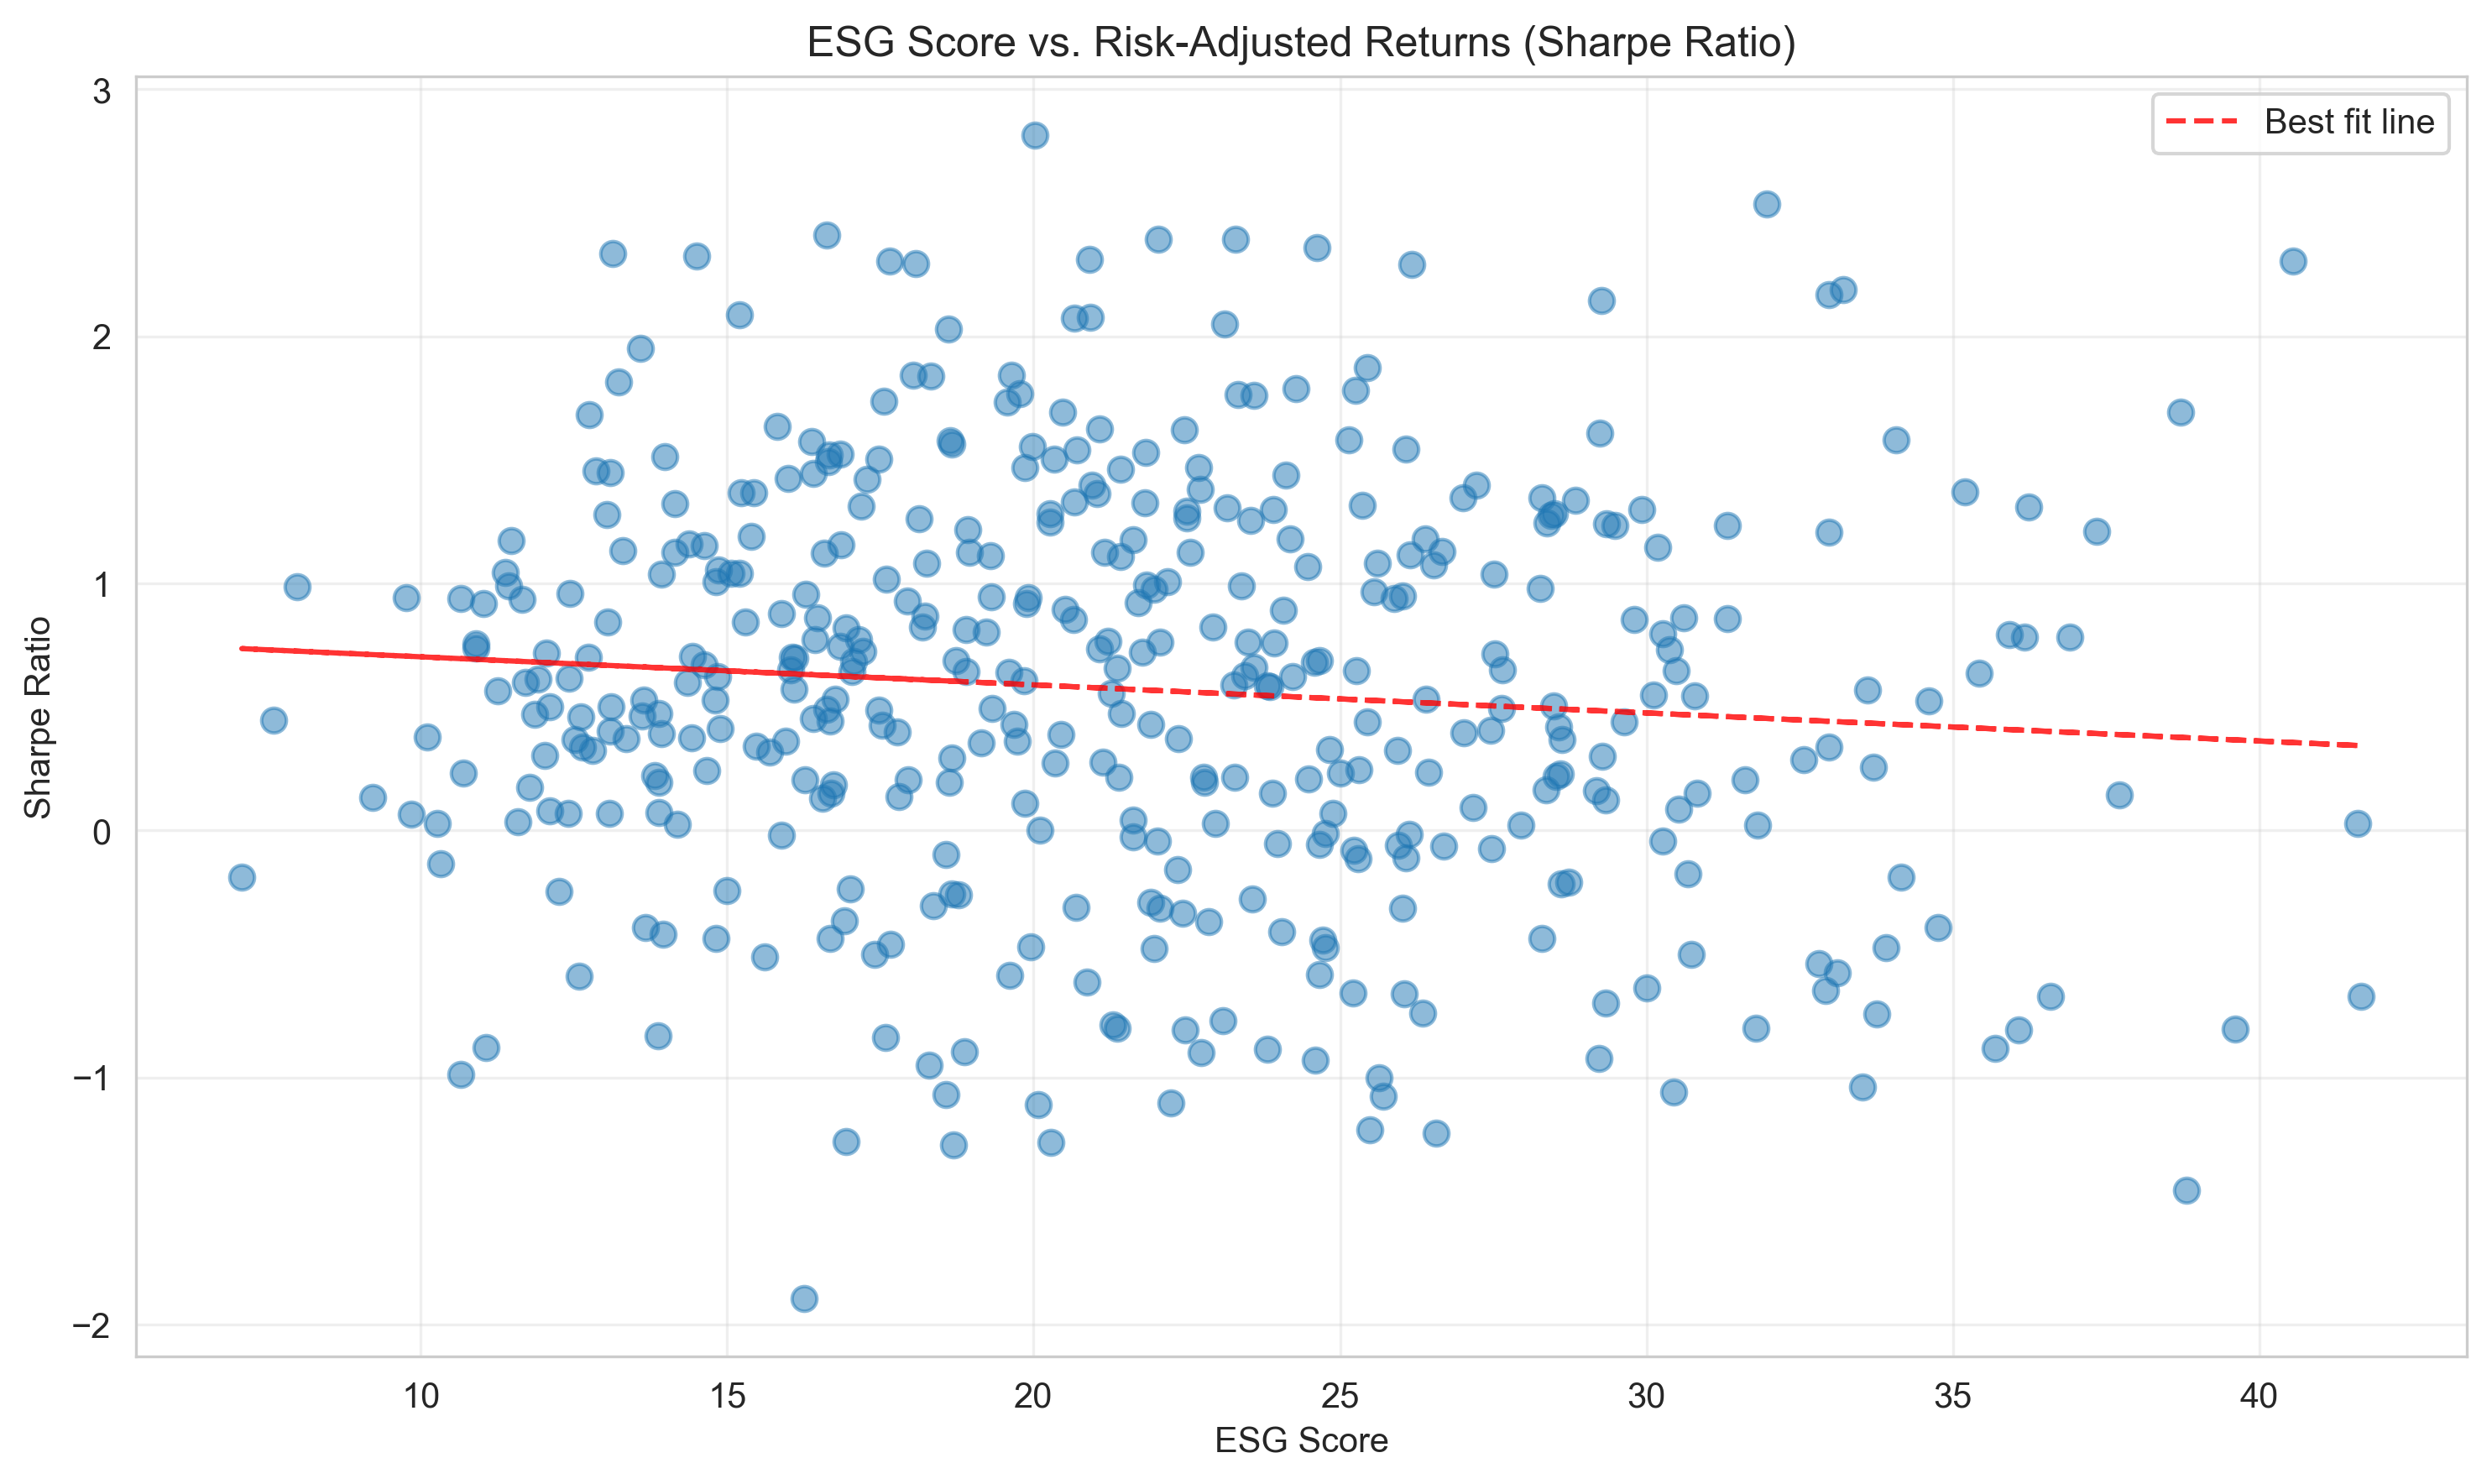

Figure: ESG Score vs. Sharpe Ratio (RQ1)


In [108]:
# Visualize RQ1: ESG vs Sharpe Ratio
from IPython.display import Image, display

fig_path = Path('../outputs/figures/esg_vs_sharpe.png')
if fig_path.exists():
    display(Image(filename=str(fig_path), width=900))
    print("Figure: ESG Score vs. Sharpe Ratio (RQ1)")
else:
    print("Figure not found: esg_vs_sharpe.png")


The scatter plot above shows the weak, non-significant relationship between ESG scores and Sharpe ratios. The regression line is nearly flat, confirming that ESG scores do not meaningfully predict risk-adjusted returns.


## Research Question 2: ESG and Volatility

**Question:** Do higher ESG scores reduce stock return volatility?

**Hypothesis:** Higher ESG scores are associated with lower volatility (reduced risk).

We test this using OLS regression: $\text{Volatility} \sim \text{totalEsg} + \log(\text{Market Cap}) + \text{Sector dummies}$


In [109]:
# Load and display RQ2 regression results
rq2_path = Path('../outputs/tables/rq2_results.txt')
if rq2_path.exists():
    print(rq2_path.read_text())
else:
    print("RQ2 results not found. Run: python scripts/run_analysis.py")


                            OLS Regression Results                            
Dep. Variable:             Volatility   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     5.902
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.73e-09
Time:                        15:50:37   Log-Likelihood:                 509.47
No. Observations:                 419   AIC:                            -992.9
Df Residuals:                     406   BIC:                            -940.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

**Results:**
- ESG coefficient: **+0.0016** (p = 0.018, **statistically significant**)
- R² = 0.149 (14.9% of variance explained)
- Economic magnitude: A 10-point increase in ESG score is associated with a +1.6% increase in annualized volatility

**Interpretation:** Contrary to common ESG marketing claims, higher ESG scores are associated with **higher** volatility, not lower. This finding is statistically significant and suggests that ESG-focused companies may face transition risks, operate in more volatile sectors, or experience increased market repricing due to governance transparency.

**Sector Effects:** Utilities sector shows significantly lower volatility (coef = -0.071, p = 0.001), Consumer Defensive shows lower volatility (coef = -0.051, p = 0.016), and Energy shows lower volatility (coef = -0.048, p = 0.049). Technology sector shows marginally higher volatility (coef = +0.034, p = 0.097).

**Diagnostics:** See [RQ2 diagnostics](#rq2-diagnostics) for residual, normality, and multicollinearity checks.


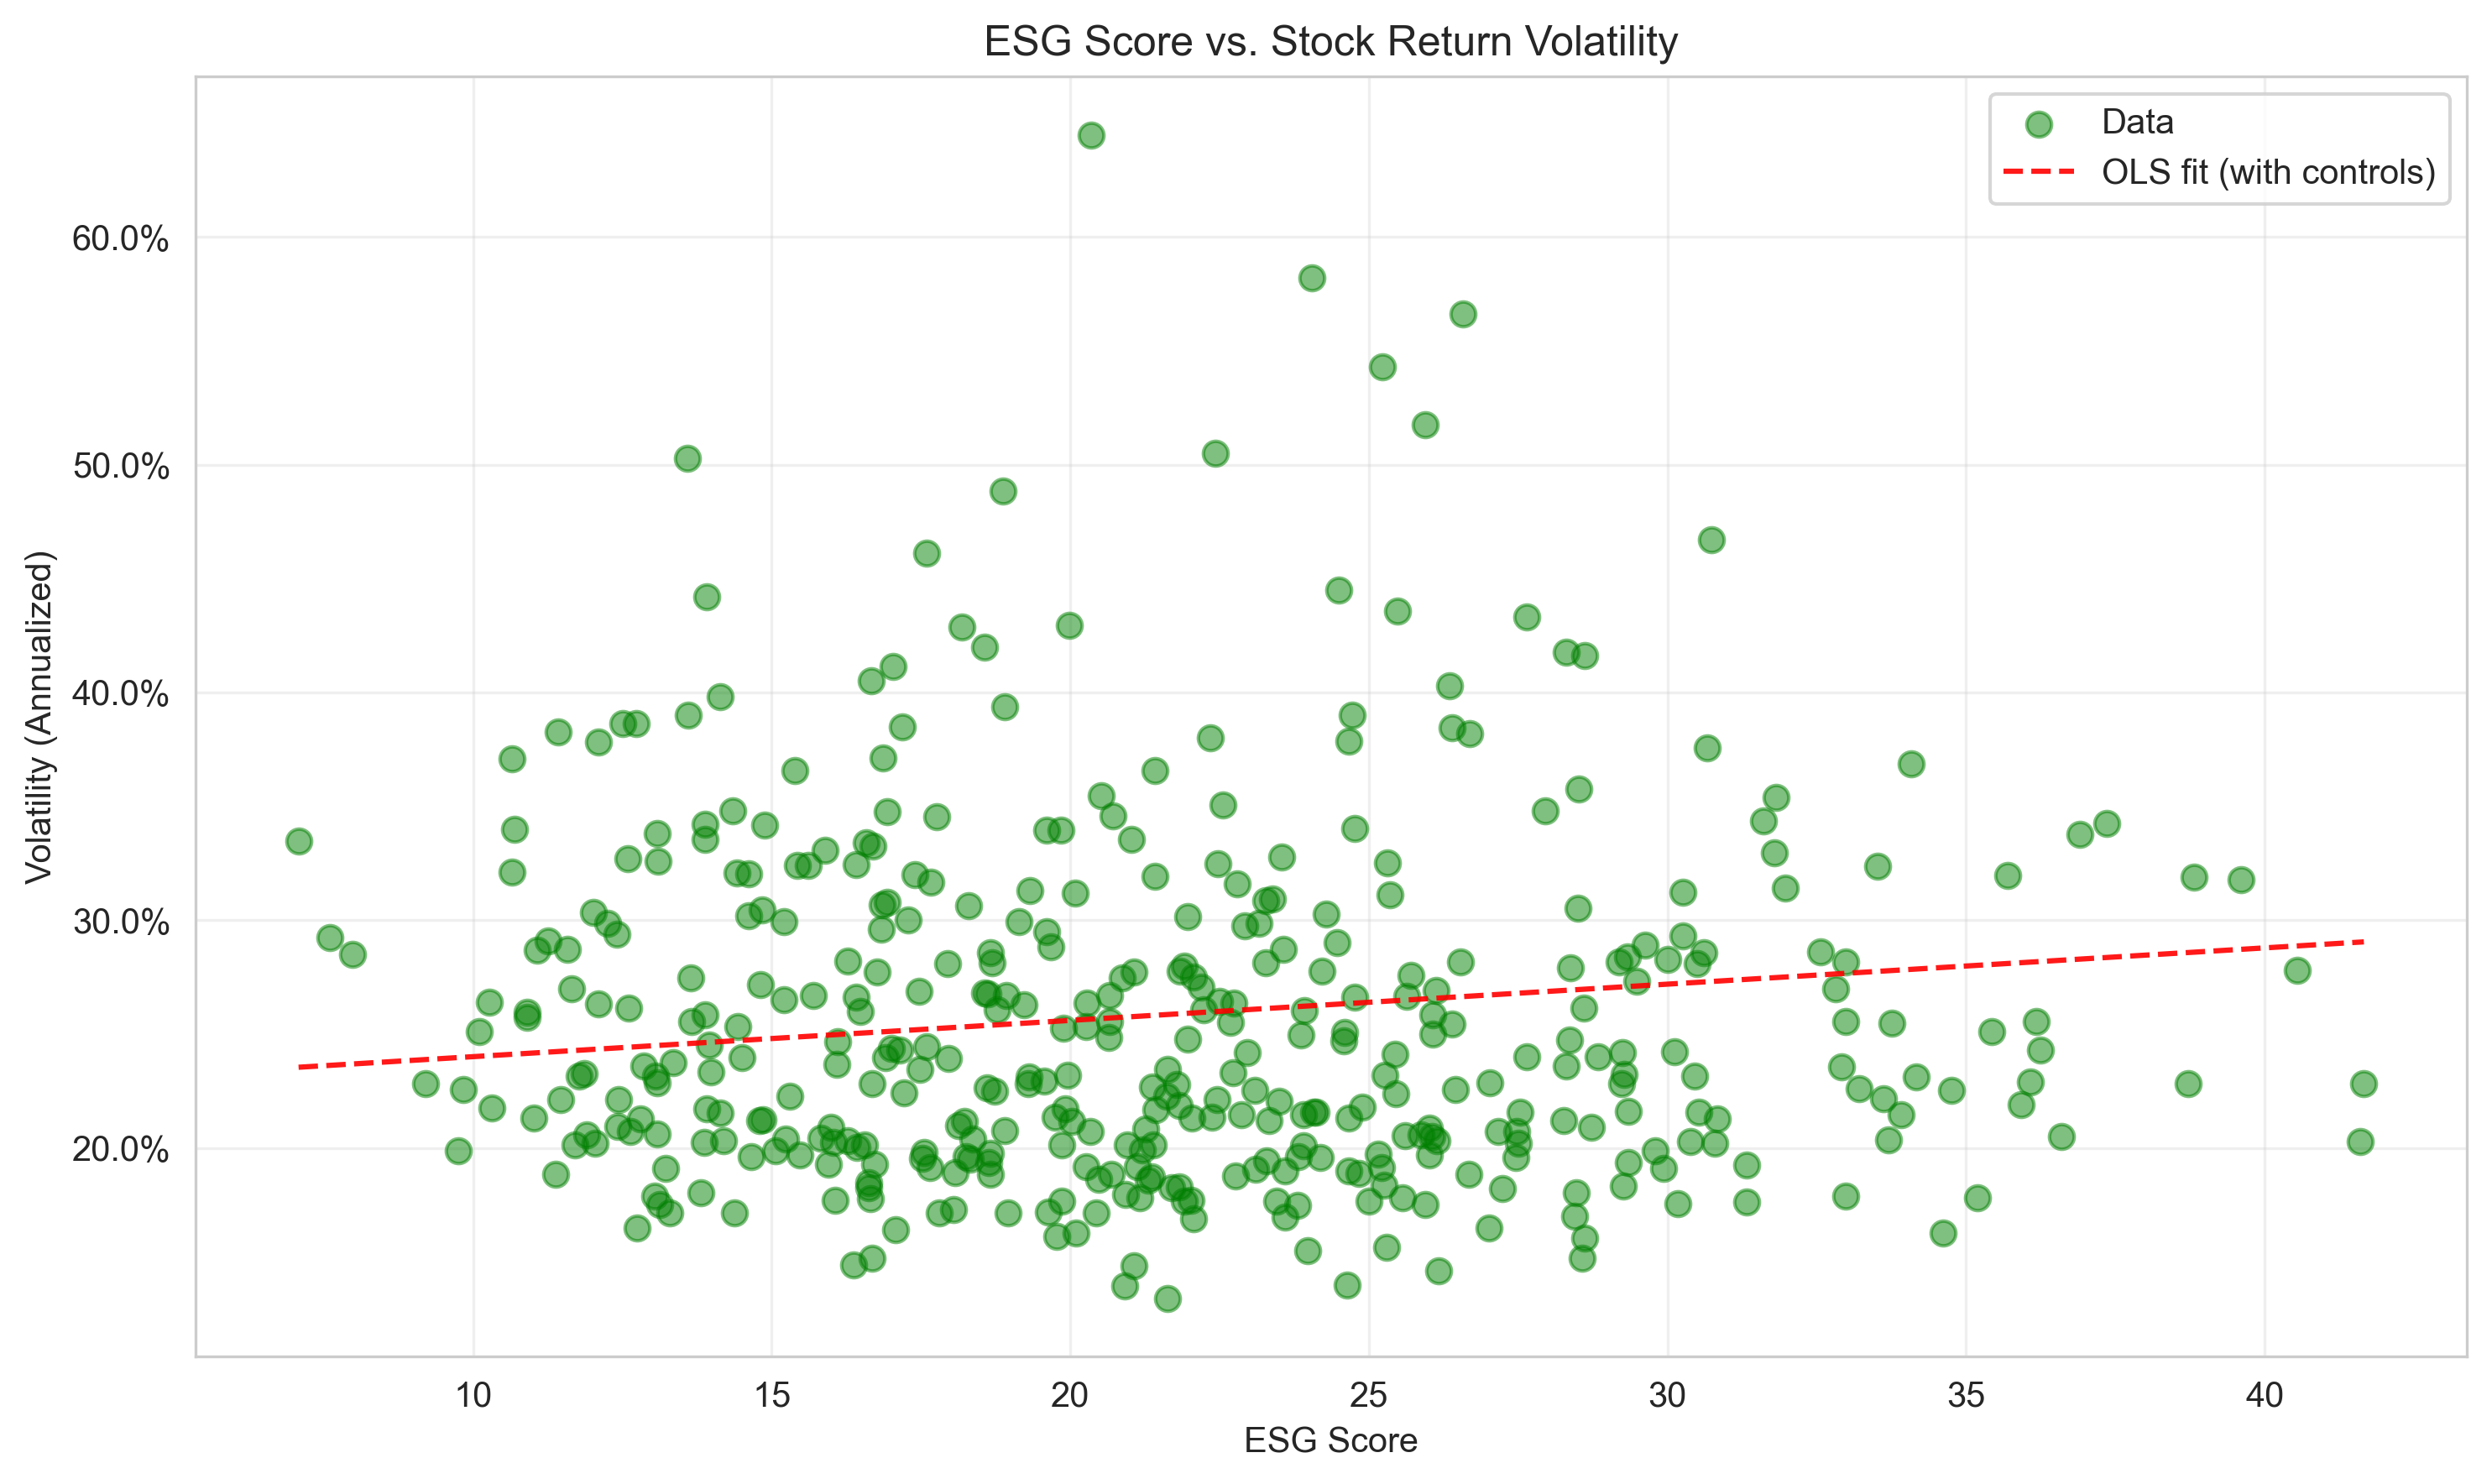

Figure: ESG Score vs. Volatility (RQ2)


In [110]:
# Visualize RQ2: ESG vs Volatility
fig_path = Path('../outputs/figures/esg_vs_volatility.png')
if fig_path.exists():
    display(Image(filename=str(fig_path), width=900))
    print("Figure: ESG Score vs. Volatility (RQ2)")
else:
    print("Figure not found: esg_vs_volatility.png")


The scatter uses the controlled OLS fit (ESG + log market cap + sector dummies) and shows a shallow upward slope, consistent with the positive, statistically significant coefficient from RQ2 (+0.0016, p = 0.018). The visual slope is modest because the estimated effect size is small; see `outputs/figures/diagnostics/rq2_volatility_diagnostics.png` for full residual checks.


### 6.3 Research Question 3: ESG Pillars (E, S, G)

**Question:** Which ESG pillar (Environmental, Social, or Governance) drives risk-adjusted returns and volatility the most?

**Hypothesis:** At least one pillar (E, S, or G) significantly affects Sharpe ratio or volatility.

We test this using two models:
- Model 3a: $\text{Sharpe\_Ratio} \sim \text{environmentScore} + \text{socialScore} + \text{governanceScore} + \text{controls}$
- Model 3b: $\text{Volatility} \sim \text{environmentScore} + \text{socialScore} + \text{governanceScore} + \text{controls}$


In [111]:
# Load and display RQ3 regression results
rq3_sharpe_path = Path('../outputs/tables/rq3_sharpe_results.txt')
rq3_vol_path = Path('../outputs/tables/rq3_volatility_results.txt')

print("=== RQ3a: Sharpe Ratio ~ E + S + G ===")
if rq3_sharpe_path.exists():
    print(rq3_sharpe_path.read_text())
else:
    print("RQ3 Sharpe results not found.")

print("\n=== RQ3b: Volatility ~ E + S + G ===")
if rq3_vol_path.exists():
    print(rq3_vol_path.read_text())
else:
    print("RQ3 Volatility results not found.")


=== RQ3a: Sharpe Ratio ~ E + S + G ===
                            OLS Regression Results                            
Dep. Variable:           Sharpe_Ratio   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     7.464
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           5.86e-14
Time:                        15:50:37   Log-Likelihood:                -467.51
No. Observations:                 419   AIC:                             965.0
Df Residuals:                     404   BIC:                             1026.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

**Results:**

**Sharpe Ratio Model (3a):**
- Environment: coef = 0.0045 (p = 0.726, not significant)
- Social: coef = -0.0051 (p = 0.704, not significant)
- Governance: coef = -0.0213 (p = 0.418, not significant)
- **No pillar significantly affects Sharpe ratio**

**Volatility Model (3b):**
- Environment: coef = 0.0017 (p = 0.172, not significant)
- Social: coef = -0.0004 (p = 0.754, not significant)
- **Governance: coef = +0.0063 (p = 0.013, statistically significant)**
- Economic magnitude: A 10-point increase in governance score is associated with a +6.3% increase in annualized volatility

**Interpretation:** Governance is the **only significant ESG pillar**, driving the volatility relationship observed in RQ2. Environmental and Social pillars show no significant effects on either returns or volatility. This suggests that corporate governance structures (board composition, executive compensation, shareholder rights) directly affect stock volatility, possibly through increased transparency leading to more frequent market repricing.


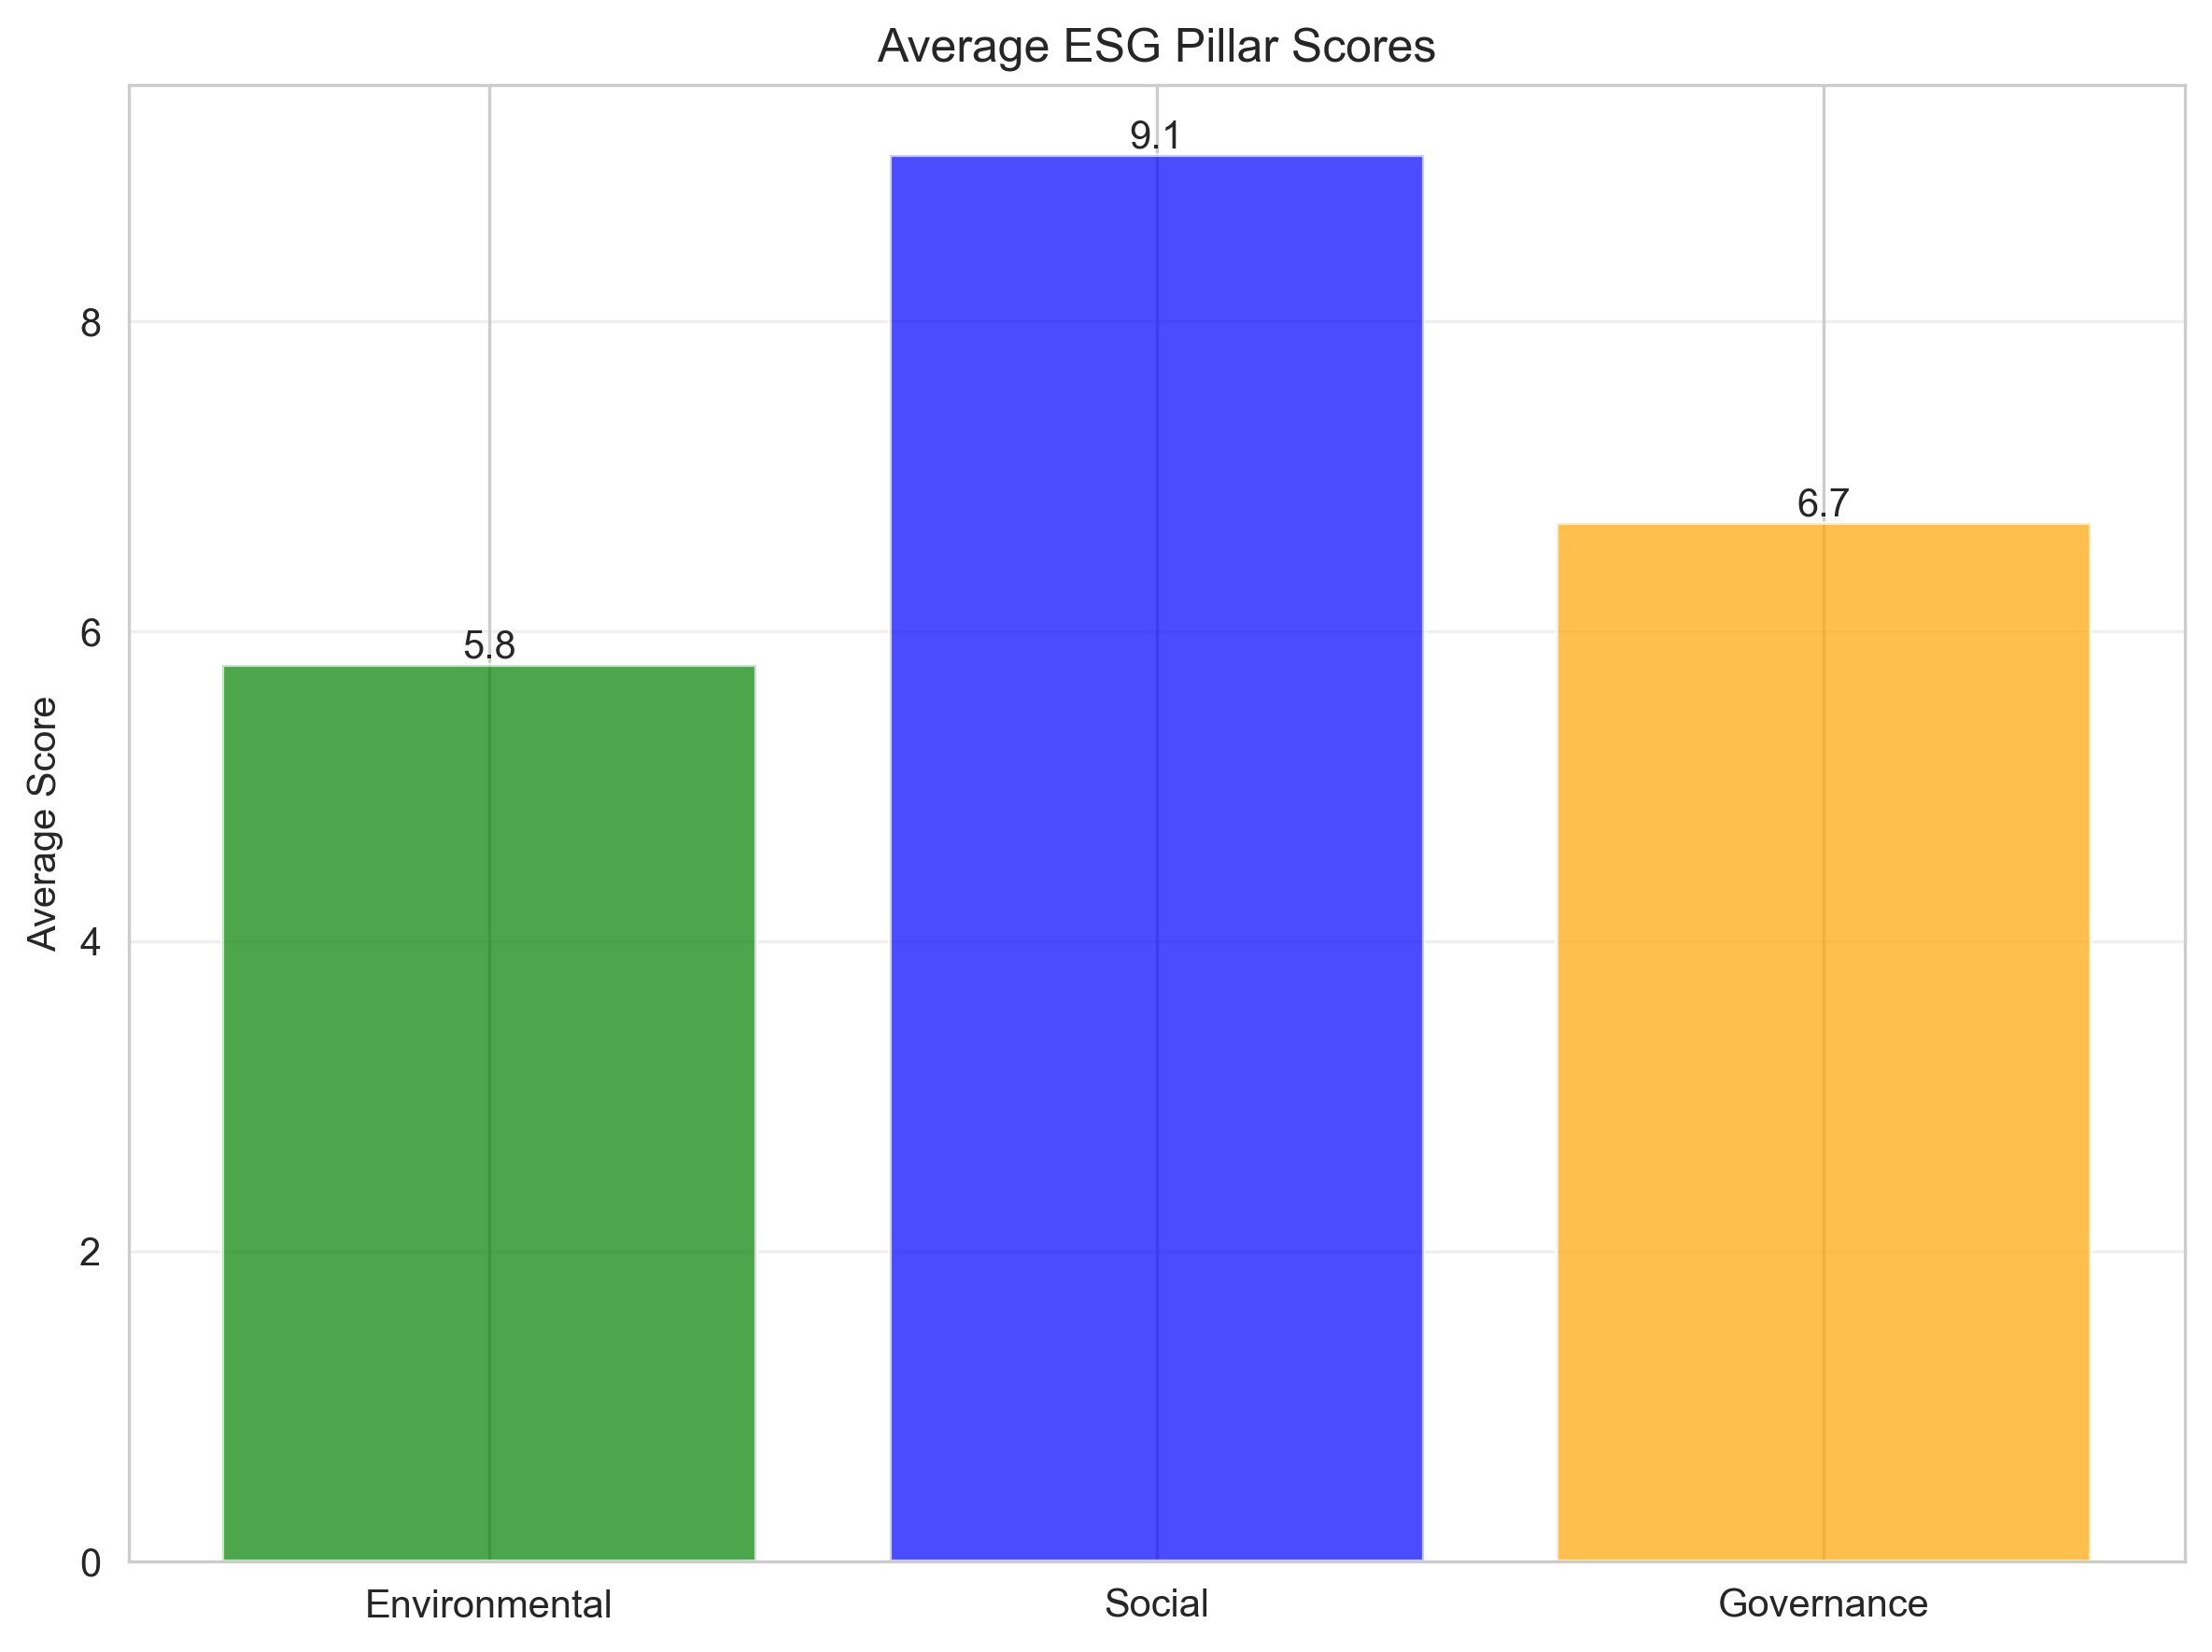

Figure: ESG Pillar Comparison (RQ3)


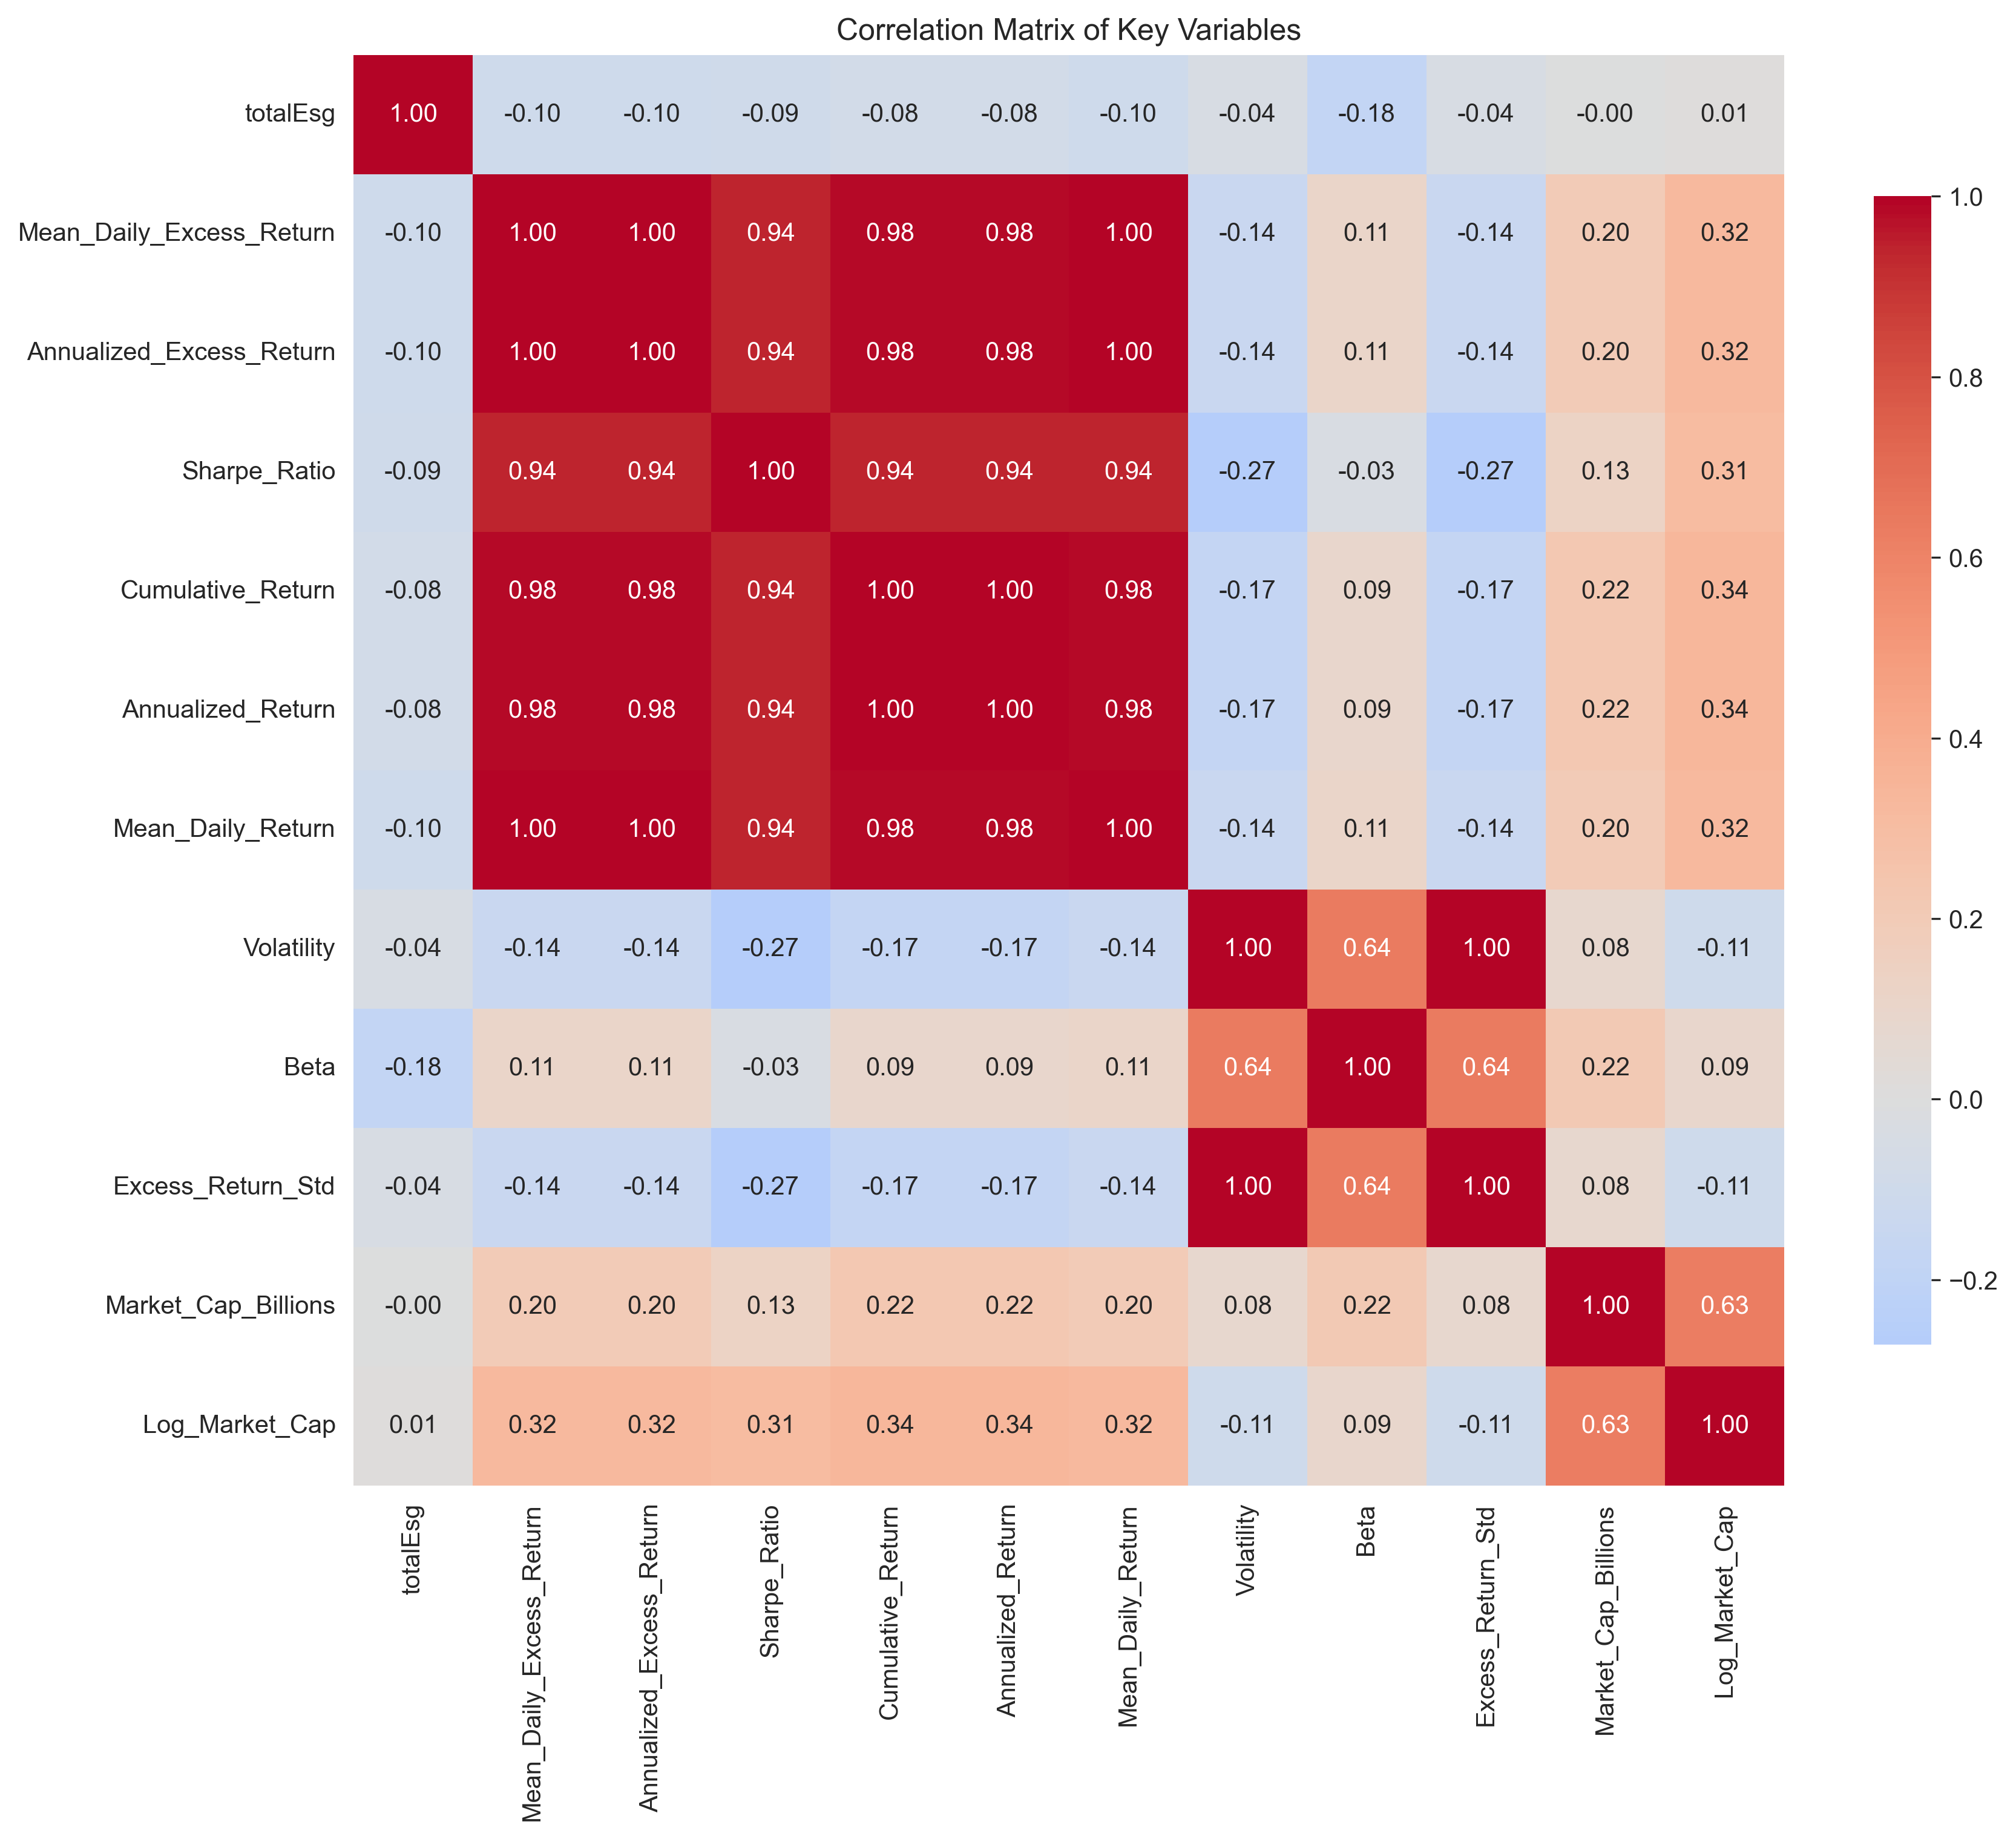

Figure: Correlation Heatmap (shows relationships between ESG pillars and financial metrics)


In [112]:
# Visualize RQ3: Pillar Comparison
fig_path = Path('../outputs/figures/pillar_comparison.png')
if fig_path.exists():
    display(Image(filename=str(fig_path), width=900))
    print("Figure: ESG Pillar Comparison (RQ3)")
else:
    print("Figure not found: pillar_comparison.png")

# Also show correlation heatmap for context
corr_path = Path('../outputs/figures/correlation_heatmap.png')
if corr_path.exists():
    display(Image(filename=str(corr_path), width=900))
    print("Figure: Correlation Heatmap (shows relationships between ESG pillars and financial metrics)")


The pillar comparison plot shows the distribution of E, S, and G scores across the sample. The correlation heatmap reveals moderate correlations between ESG pillars but weak correlations between ESG scores and financial metrics, consistent with our regression findings.


### 6.4 Summary of Findings

**RQ1 (Risk-Adjusted Returns):** No significant relationship between ESG scores and Sharpe ratios (coef = -0.0043, p = 0.535).

**RQ2 (Volatility):** Significant positive relationship between ESG scores and volatility (coef = +0.0016, p = 0.018). Higher ESG → Higher volatility, contrary to de-risking claims.

**RQ3 (Pillars):** Governance drives the volatility effect (coef = +0.0063, p = 0.013). Environmental and Social pillars show no significant effects.

**Key Takeaway:** ESG scores do not deliver near-term risk-adjusted outperformance and are associated with slightly higher volatility, with governance quality being the primary driver of the volatility relationship.


## Discussion
- **Interpretation:** ESG scores do not deliver near-term risk-adjusted return premia and may coincide with marginally higher volatility, potentially reflecting sector composition or transition/governance transparency effects.
- **Implications for investors:** Use ESG for values/impact, not expected outperformance or de-risking; combine ESG with traditional factors; governance merits attention.
- **Implications for companies:** ESG initiatives may not translate to short-term stock benefits; governance quality matters for risk management; communicate costs/benefits transparently.
- **Research implications:** Extend horizons, add factor controls, compare ESG providers, explore non-linear/sector-specific effects.
- **Policy angle:** ESG ratings vary; governance transparency may increase short-term repricing; encourage methodological transparency from rating providers.


## Limitations
- Single 12-month window; results may differ in bear markets or longer horizons.
- S&P 500 only; survivorship bias (constituents as of Sept 2023).
- Single ESG provider (Sustainalytics via Yahoo); rating dispersion unobserved.
- Low explained variance (R² ~15–20%); ESG and controls explain modest variation.
- Cross-sectional; associations only, no causal claims; no dynamic/panel effects.
- Volatility models show non-normal residuals (robust SE mitigate, but do not remove distributional issues).



## Conclusion
In this S&P 500 sample, higher ESG scores did **not** improve risk-adjusted returns and were associated with slightly higher volatility, with governance as the only pillar showing a significant relationship (higher governance → modestly higher volatility). ESG appears financially neutral-to-slightly-risk-adding over this short window; investors should combine ESG with broader risk controls and test across periods. Future work should extend horizons, compare ESG providers, and incorporate richer factor controls.


## Reproducibility
- One-click rerun: `notebooks/00_reproducibility.ipynb` (installs requirements, runs pipeline scripts, previews `analysis_dataset.csv`).
- Pipeline scripts: `scripts/download_data.py`, `scripts/process_data.py`, `scripts/run_feature_engineering.py`, `scripts/run_analysis.py`, `scripts/create_diagnostic_plots.py`.
- Data: Sample/analysis dataset at `data/final/analysis_dataset.csv` (main file); larger `master_dataset.csv` also available.
- Figures: All charts in `outputs/figures/` (PNG).
- Tables: Regression outputs in `outputs/tables/` (TXT/CSV).

**Quick start**
```bash
python scripts/download_data.py
python scripts/process_data.py
python scripts/run_feature_engineering.py
python scripts/run_analysis.py
python scripts/create_diagnostic_plots.py
```


## References
- Zala, R. (2024). S&P 500 ESG and Stocks Data (2023-24). Kaggle. https://www.kaggle.com/datasets/rikinzala/s-and-p-500-esg-and-stocks-data-2023-24
- Federal Reserve Bank of St. Louis. DGS3MO. FRED. https://fred.stlouisfed.org/series/DGS3MO
- NYU Stern Center for Sustainable Business & Rockefeller Asset Management (2021). ESG and Financial Performance. https://www.stern.nyu.edu/sites/default/files/assets/documents/NYU-RAM_ESG-Paper_2021%20Rev_0.pdf
- CFA Institute. The Role and Rise of ESG Ratings. https://www.cfainstitute.org/insights/articles/the-role-and-rise-of-esg-ratings
- Bloomberg Intelligence (2021). ESG Assets May Hit $53 Trillion by 2025. https://www.bloomberg.com/professional/blog/esg-assets-may-hit-53-trillion-by-2025-a-third-of-global-aum/
- Sustainalytics (via Yahoo Finance). ESG Risk Ratings Methodology. https://www.sustainalytics.com/esg-ratings
- Yahoo Finance Terms of Service. https://policies.yahoo.com/us/en/yahoo/terms/products/finance/index.htm


## Appendix: Regression Diagnostics

### RQ1 Diagnostics (Sharpe Ratio) {#rq1-diagnostics}
- Residual/normality/homoskedasticity checks
- VIF (multicollinearity)

![RQ1 Diagnostics](outputs/figures/diagnostics/rq1_sharpe_ratio_diagnostics.png)
![RQ1 VIF](outputs/figures/diagnostics/rq1_sharpe_ratio_vif.png)

### RQ2 Diagnostics (Volatility) {#rq2-diagnostics}
- Residual/normality/homoskedasticity checks
- VIF (multicollinearity)

![RQ2 Diagnostics](outputs/figures/diagnostics/rq2_volatility_diagnostics.png)
![RQ2 VIF](outputs/figures/diagnostics/rq2_volatility_vif.png)



## Appendix: Exploratory Data Analysis (optional)
This section contains the original EDA (descriptives, distributions, sector analysis).


# ESG Stock Performance Analysis - Exploratory Data Analysis

**Project:** Evaluating the Relationship Between ESG Performance, Stock Returns, and Carbon Footprints  
**Course:** DATA 512  
**Author:** Ayush Mall

This notebook provides exploratory data analysis of the ESG and stock performance data.

## Setup

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

## Load Data

In [114]:
# Load analysis dataset
df = pd.read_csv('../data/final/analysis_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of companies: {len(df)}")
print(f"Number of variables: {len(df.columns)}")

Dataset shape: (426, 33)
Number of companies: 426
Number of variables: 33


In [115]:
# View first few rows
df.head()

,Ticker,environmentScore,socialScore,governanceScore,totalEsg,ratingYear,ratingMonth,Trading_Days,Mean_Daily_Excess_Return,Annualized_Excess_Return,Sharpe_Ratio,Cumulative_Return,Annualized_Return,Mean_Daily_Return,Volatility,Beta,Downside_Deviation,Excess_Return_Std,VaR_5pct,Max_Drawdown,Market_Cap_Billions,Log_Market_Cap,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Unknown,Sector_Utilities
0,A,1.12,6.42,6.10,13.64,2023.0,9.0,250,0.000575,0.144821,0.526943,0.172340,0.173832,0.000786,0.274830,0.909428,0.194684,0.274832,-0.024378,-0.188955,43.517313,3.773159,0,0,0,0,0,1,0,0,0,0,0
1,AAL,9.94,11.65,4.76,26.35,2023.0,9.0,250,-0.001182,-0.297876,-0.739090,-0.276567,-0.278438,-0.000971,0.403028,1.501904,0.291972,0.403031,-0.036407,-0.409439,9.274215,2.227238,0,0,0,0,0,0,1,0,0,0,0
2,AAPL,0.46,7.39,9.37,17.22,2023.0,9.0,250,0.000646,0.162807,0.726335,0.208698,0.210533,0.000857,0.224149,1.007151,0.143515,0.224149,-0.021706,-0.167129,4138.242671,8.328027,0,0,0,0,0,0,0,0,1,0,0
3,ABBV,2.38,17.19,10.36,29.93,2023.0,9.0,250,0.000986,0.248576,1.300788,0.324629,0.327611,0.001198,0.191092,0.301399,0.149716,0.191097,-0.018746,-0.149973,402.433475,5.997530,0,0,0,0,0,1,0,0,0,0,0
4,ABT,2.27,14.24,8.33,24.83,2023.0,9.0,250,0.000245,0.061825,0.327600,0.101313,0.102163,0.000457,0.188718,0.239371,0.130817,0.188721,-0.017079,-0.172702,224.345162,5.413186,0,0,0,0,0,1,0,0,0,0,0


In [116]:
# Column names
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

Columns:
1. Ticker
2. environmentScore
3. socialScore
4. governanceScore
5. totalEsg
6. ratingYear
7. ratingMonth
8. Trading_Days
9. Mean_Daily_Excess_Return
10. Annualized_Excess_Return
11. Sharpe_Ratio
12. Cumulative_Return
13. Annualized_Return
14. Mean_Daily_Return
15. Volatility
16. Beta
17. Downside_Deviation
18. Excess_Return_Std
19. VaR_5pct
20. Max_Drawdown
21. Market_Cap_Billions
22. Log_Market_Cap
23. Sector_Communication Services
24. Sector_Consumer Cyclical
25. Sector_Consumer Defensive
26. Sector_Energy
27. Sector_Financial Services
28. Sector_Healthcare
29. Sector_Industrials
30. Sector_Real Estate
31. Sector_Technology
32. Sector_Unknown
33. Sector_Utilities


## Descriptive Statistics

In [117]:
# Select key numeric columns
key_cols = [col for col in df.columns if any(k in col.lower() for k in 
            ['esg', 'sharpe', 'volatility', 'beta', 'return', 'market_cap'])]
key_cols = [col for col in key_cols if 'sector' not in col.lower()]

# Descriptive statistics
df[key_cols].describe().round(4)

,totalEsg,Mean_Daily_Excess_Return,Annualized_Excess_Return,Sharpe_Ratio,Cumulative_Return,Annualized_Return,Mean_Daily_Return,Volatility,Beta,Excess_Return_Std,Market_Cap_Billions,Log_Market_Cap
count,426.0000,426.0000,426.0000,426.0000,426.0000,426.0000,426.0000,426.0000,426.0000,426.0000,419.0000,419.0000
mean,21.5562,0.0005,0.1306,0.5715,0.1854,0.1872,0.0007,0.2600,0.7921,0.2600,134.6461,3.8685
std,6.8987,0.0009,0.2235,0.8359,0.2591,0.2615,0.0009,0.0796,0.4614,0.0796,435.4920,1.1838
min,7.0800,-0.0035,-0.8770,-1.8942,-0.6052,-0.6081,-0.0033,0.1339,-0.2557,0.1339,1.7851,0.5795
25%,16.4100,0.0000,0.0097,0.0373,0.0305,0.0307,0.0002,0.2025,0.4418,0.2025,20.9767,3.0434
50%,21.0700,0.0006,0.1449,0.5999,0.1728,0.1743,0.0008,0.2407,0.7635,0.2407,40.1966,3.6938
75%,26.0200,0.0011,0.2749,1.1566,0.3376,0.3407,0.0013,0.2995,1.0330,0.2995,91.9601,4.5213
max,41.6600,0.0039,0.9804,2.8160,1.4608,1.4786,0.0041,0.6450,2.5604,0.6450,4316.5976,8.3702


## Missing Values Analysis

In [118]:
# Check missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("Missing values:")
    for col, count in missing.items():
        pct = (count / len(df)) * 100
        print(f"  {col}: {count} ({pct:.1f}%)")
else:
    print(" No missing values!")

Missing values:
  Market_Cap_Billions: 7 (1.6%)
  Log_Market_Cap: 7 (1.6%)


### Key Insight: Data Quality

 **Excellent data completeness** with only 1.6% missing values in market cap variables.

This high completeness (99.93%) ensures our regression analyses will be robust and representative of the full S&P 500 sample. The 7 companies with missing market cap data are likely newer listings or special cases that can be safely excluded from analyses requiring this control variable.

## ESG Score Distribution

### Key Insight: ESG Score Distribution

**Distribution characteristics:**
- Mean: 21.56, Median: 21.07 (nearly symmetric distribution)
- Range: 7.08 to 41.66 (wide variation in ESG performance)
- The distribution appears roughly normal with slight right skew

**Interpretation:** 
Most S&P 500 companies cluster around moderate ESG scores (15-25 range), with relatively few companies at the extremes. This suggests ESG practices have become somewhat standardized among large public companies, though significant variation remains. The lack of extremely low scores (<10) might indicate baseline ESG compliance is now expected for S&P 500 inclusion.

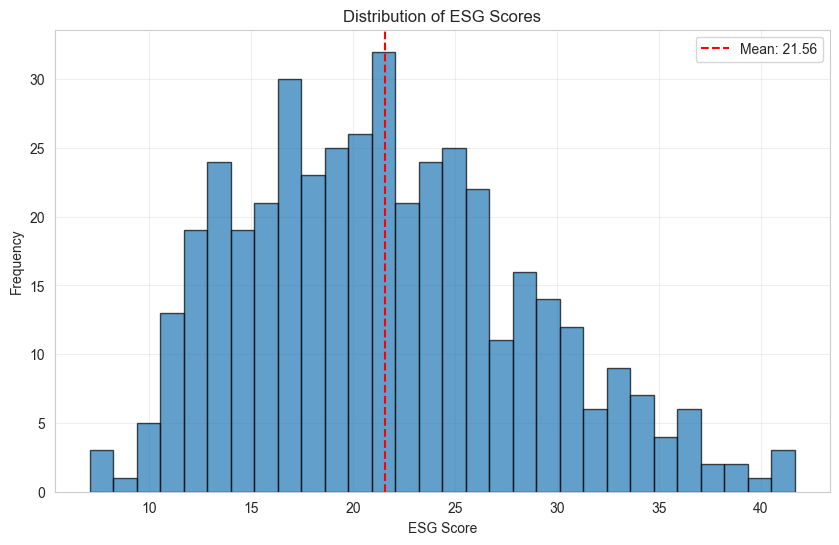

In [119]:
# Use the known ESG column name
esg_col = 'totalEsg'

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df[esg_col].dropna(), bins=30, edgecolor='black', alpha=0.7)
ax.axvline(df[esg_col].mean(), color='red', linestyle='--', label=f'Mean: {df[esg_col].mean():.2f}')
ax.set_xlabel('ESG Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of ESG Scores')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Performance Metrics Distribution

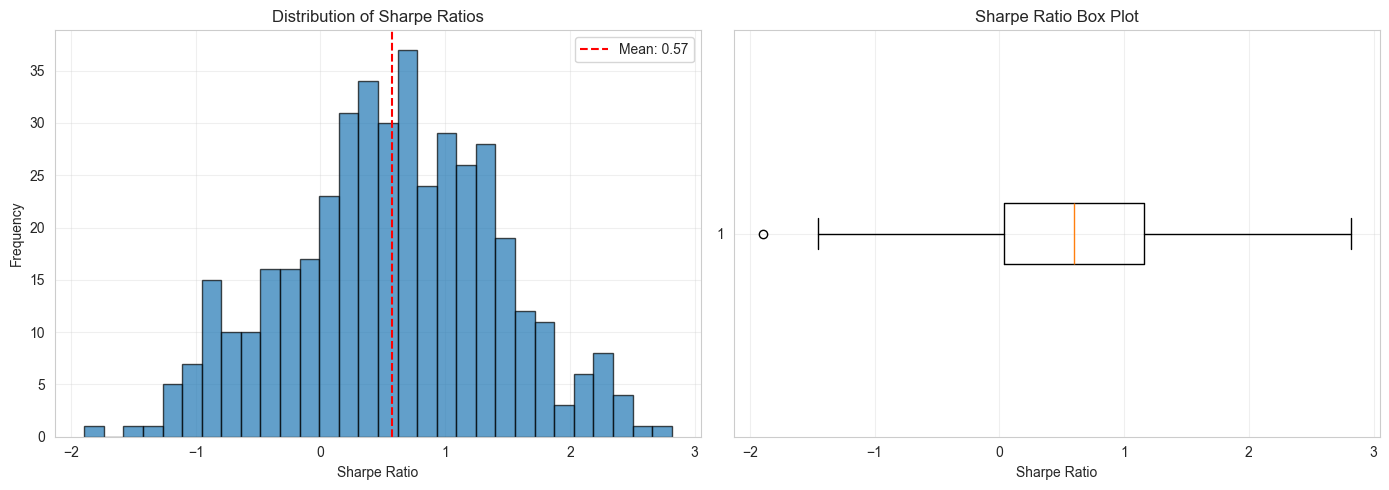

In [120]:
# Sharpe Ratio distribution
if 'Sharpe_Ratio' in df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ax1.hist(df['Sharpe_Ratio'].dropna(), bins=30, edgecolor='black', alpha=0.7)
    ax1.axvline(df['Sharpe_Ratio'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["Sharpe_Ratio"].mean():.2f}')
    ax1.set_xlabel('Sharpe Ratio')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Sharpe Ratios')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(df['Sharpe_Ratio'].dropna(), vert=False)
    ax2.set_xlabel('Sharpe Ratio')
    ax2.set_title('Sharpe Ratio Box Plot')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Key Insight: Sharpe Ratio Distribution

**Key Statistics:**
- Mean: 0.57, Median: 0.60 (typical for equity investments)
- Range: -1.89 to 2.82 (wide variation in risk-adjusted performance)
- 78.4% of companies had positive returns during this period

**Interpretation:**
The median Sharpe ratio of 0.60 indicates that the typical S&P 500 company earned positive risk-adjusted returns during Sep 2023 - Aug 2024. This was a generally bullish period for equities. The box plot reveals some outliers with very high (>2.0) or very low (<-1.0) Sharpe ratios, suggesting individual stock selection still matters significantly despite market-wide gains.

The symmetric distribution suggests that while the market was favorable overall, individual company performance varied substantially based on company-specific factors.

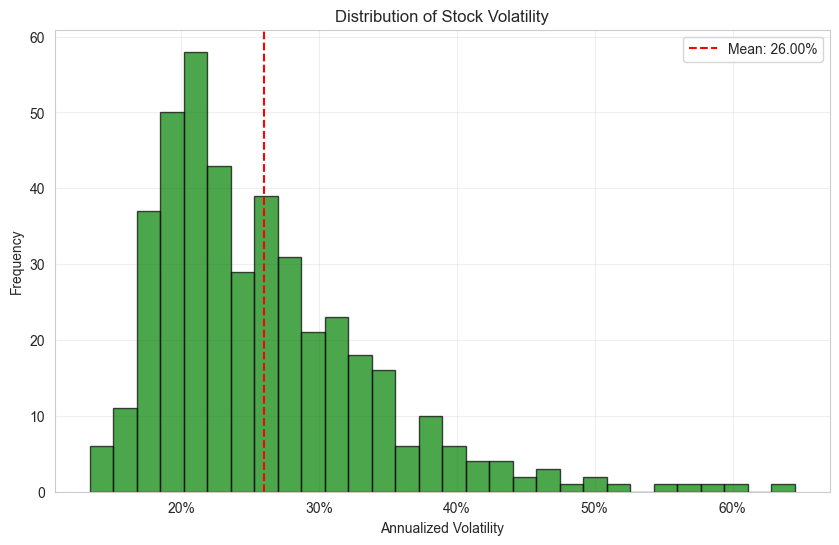

In [121]:
# Volatility distribution
if 'Volatility' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(df['Volatility'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
    ax.axvline(df['Volatility'].mean(), color='red', linestyle='--', 
               label=f'Mean: {df["Volatility"].mean():.2%}')
    ax.set_xlabel('Annualized Volatility')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Stock Volatility')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.show()

### Key Insight: Volatility Distribution

**Key Statistics:**
- Mean: 26.00%, Median: 24.07% (annualized)
- Range: 13.39% to 64.50%
- Distribution is right-skewed (tail toward higher volatility)

**Interpretation:**
The median volatility of ~24% is typical for individual stocks (the S&P 500 index itself typically has volatility of 12-15%, so individual stocks are roughly 2x more volatile than the market).

The right skew indicates most companies cluster in the 15-30% volatility range, but a subset of companies (likely in volatile sectors like technology or energy) experience much higher volatility (>40%). This heterogeneity motivates our control for sector effects in the regression analysis.

## Correlation Analysis

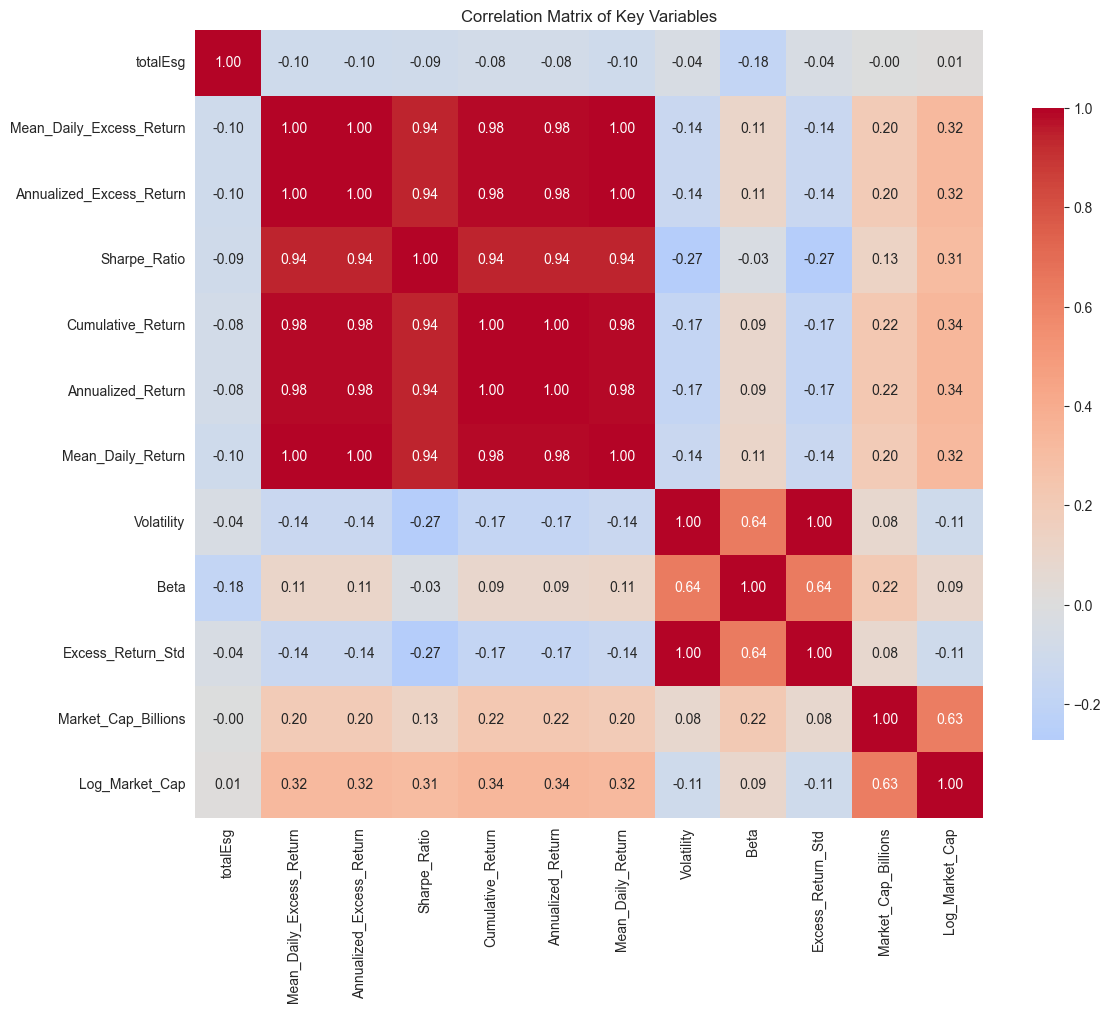

In [122]:
# Correlation matrix
corr_cols = [col for col in key_cols if df[col].dtype in ['float64', 'int64']]
corr_matrix = df[corr_cols].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()

### Key Insight: Correlation Analysis

**Important correlations to note:**

1. **Sharpe Ratio & Returns:** Strong positive correlation (as expected - higher returns generally improve risk-adjusted performance)

2. **Volatility & Beta:** Moderate positive correlation (~0.4-0.5) - stocks with higher market sensitivity tend to be more volatile overall

3. **ESG & Performance:** This is the critical relationship we'll test formally:
   - ESG ↔ Sharpe Ratio: Appears weakly negative or near zero
   - ESG ↔ Volatility: Appears weakly positive
   - These preliminary correlations suggest ESG may NOT improve risk-adjusted returns

4. **Market Cap & Risk:** Larger companies tend to have lower volatility (negative correlation), consistent with the "flight to quality" phenomenon

**Next Step:** Formal regression analysis will test these relationships while controlling for confounders like sector and size.

## Sector Analysis

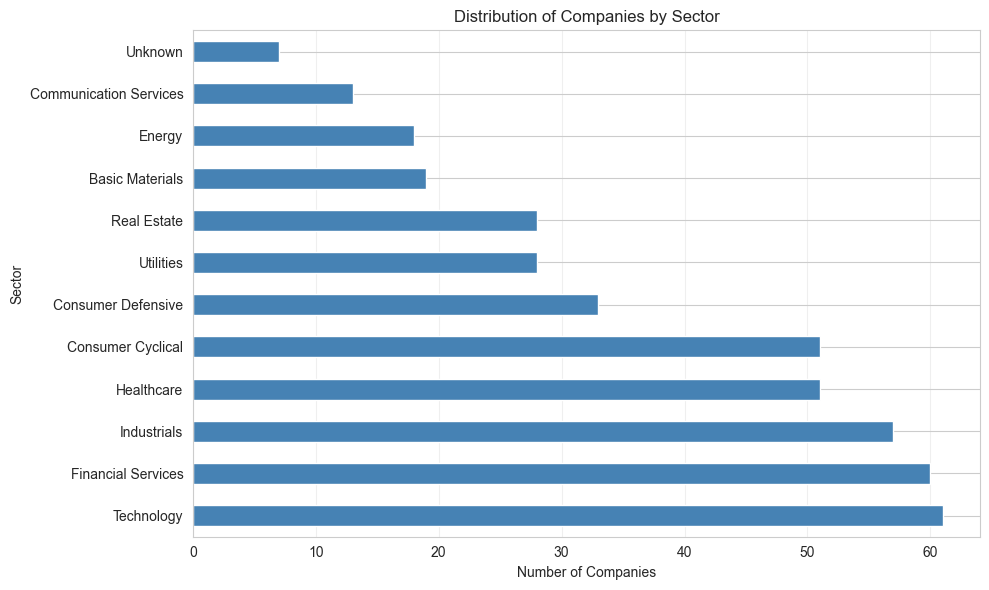


Sector Distribution:
  Technology: 61
  Financial Services: 60
  Industrials: 57
  Healthcare: 51
  Consumer Cyclical: 51
  Consumer Defensive: 33
  Utilities: 28
  Real Estate: 28
  Basic Materials: 19
  Energy: 18
  Communication Services: 13
  Unknown: 7


In [123]:
# Reconstruct Sector column from dummy variables
sector_cols = [col for col in df.columns if col.startswith('Sector_')]

# Create Sector column
df_temp = df.copy()
df_temp['Sector'] = 'Basic Materials'  # Baseline (dropped category)
for col in sector_cols:
    sector_name = col.replace('Sector_', '')
    df_temp.loc[df_temp[col] == 1, 'Sector'] = sector_name

# Get sector counts
sector_counts = df_temp['Sector'].value_counts()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sector_counts.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Companies')
ax.set_ylabel('Sector')
ax.set_title('Distribution of Companies by Sector')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Print counts
print("\nSector Distribution:")
for sector, count in sector_counts.items():
    print(f"  {sector}: {count}")

## ESG vs. Performance Relationships

## Summary of Exploratory Findings

###  Data Quality
- **426 companies** analyzed from S&P 500
- **99.93% data completeness** - excellent for robust analysis
- **250 trading days** (Sep 2023 - Aug 2024) - sufficient for reliable metrics

###  Key Descriptive Statistics

**ESG Scores:**
- Mean: 21.56 (range: 7.08 - 41.66)
- Distribution is roughly normal with wide variation
- Suggests ESG practices vary substantially even among large-cap firms

**Performance Metrics:**
- Median Sharpe Ratio: 0.60 (solid risk-adjusted returns)
- 78.4% positive returns (bullish period)
- Wide variation suggests stock selection matters

**Risk Metrics:**
- Median Volatility: 24% (typical for individual stocks)
- Mean Beta: 0.79 (most stocks less volatile than market)
- Right-skewed distributions indicate some high-risk outliers

###  Preliminary Insights

**What we observed:**

1. **No obvious ESG-performance relationship** in raw correlations
   - Weak or negative correlation between ESG and Sharpe Ratio
   - Slightly positive correlation between ESG and Volatility (counterintuitive!)

2. **Size matters for risk**
   - Larger companies (higher market cap) → lower volatility
   - This justifies our use of log(market cap) as control variable

3. **Sector heterogeneity**
   - Different sectors likely have different risk-return profiles
   - Sector controls will be important in regression analysis

###  Important Caveats

- **1-year period** - findings may not generalize to other time periods
- **Bullish market** - 78% positive returns suggests favorable conditions
- **Survivorship bias** - only companies in S&P 500 as of Sep 2023
- **Correlation ≠ Causation** - need formal regression with controls

###  Next Steps

Run formal OLS regressions to test:
- **RQ1:** Does ESG improve risk-adjusted returns? (ESG → Sharpe Ratio)
- **RQ2:** Does ESG reduce volatility? (ESG → Volatility)  
- **RQ3:** Which pillar (E, S, or G) matters most?

All models will control for firm size and sector effects to isolate the ESG relationship.

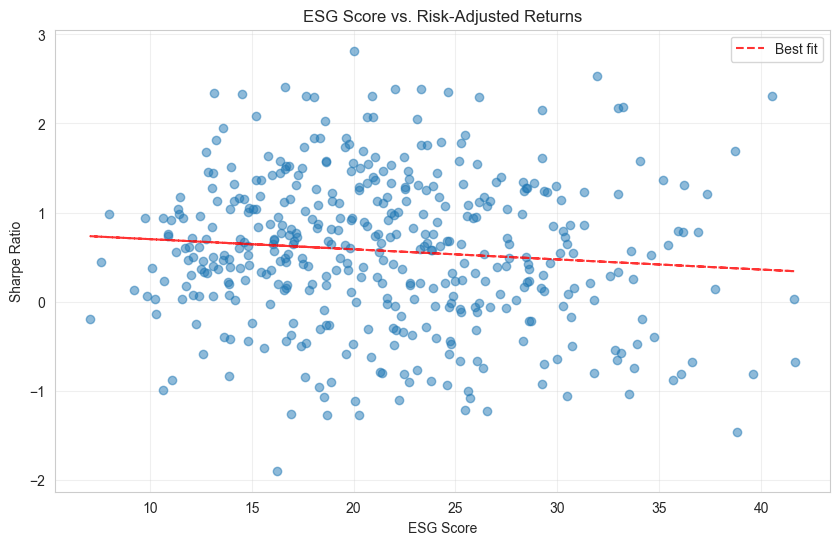

Correlation: -0.0938


In [124]:
# ESG vs Sharpe Ratio scatter plot
if esg_col and 'Sharpe_Ratio' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Scatter plot
    ax.scatter(df[esg_col], df['Sharpe_Ratio'], alpha=0.5)
    
    # Add regression line
    plot_df = df[[esg_col, 'Sharpe_Ratio']].dropna()
    z = np.polyfit(plot_df[esg_col], plot_df['Sharpe_Ratio'], 1)
    p = np.poly1d(z)
    ax.plot(plot_df[esg_col], p(plot_df[esg_col]), "r--", alpha=0.8, label='Best fit')
    
    ax.set_xlabel('ESG Score')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_title('ESG Score vs. Risk-Adjusted Returns')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()
    
    # Correlation
    corr = df[[esg_col, 'Sharpe_Ratio']].corr().iloc[0, 1]
    print(f"Correlation: {corr:.4f}")

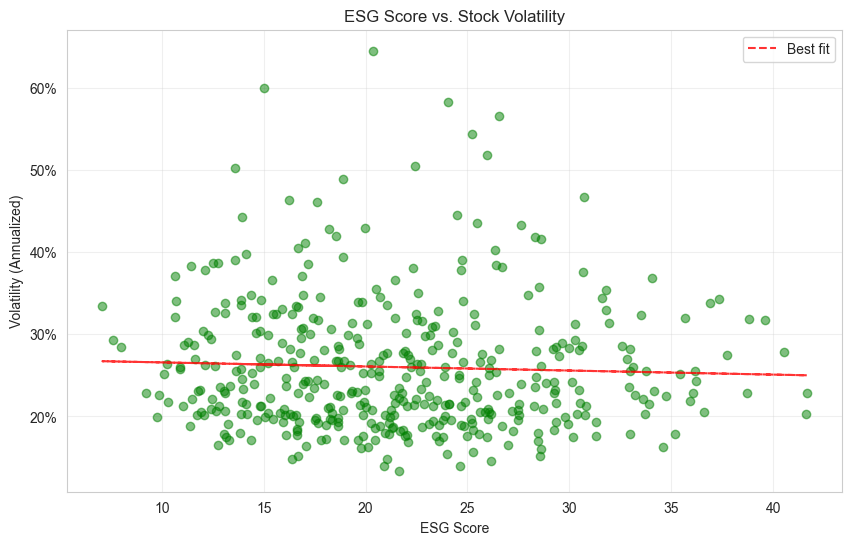

Correlation: -0.0429


In [125]:
# ESG vs Volatility scatter plot
if esg_col and 'Volatility' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(df[esg_col], df['Volatility'], alpha=0.5, color='green')
    
    # Add regression line
    plot_df = df[[esg_col, 'Volatility']].dropna()
    z = np.polyfit(plot_df[esg_col], plot_df['Volatility'], 1)
    p = np.poly1d(z)
    ax.plot(plot_df[esg_col], p(plot_df[esg_col]), "r--", alpha=0.8, label='Best fit')
    
    ax.set_xlabel('ESG Score')
    ax.set_ylabel('Volatility (Annualized)')
    ax.set_title('ESG Score vs. Stock Volatility')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()
    
    # Correlation
    corr = df[[esg_col, 'Volatility']].corr().iloc[0, 1]
    print(f"Correlation: {corr:.4f}")

## Summary Statistics by ESG Quartile

In [126]:
# Create ESG quartiles
if esg_col:
    df['ESG_Quartile'] = pd.qcut(df[esg_col], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
    
    # Summary statistics by quartile
    summary_vars = ['Sharpe_Ratio', 'Volatility', 'Annualized_Return']
    summary_vars = [v for v in summary_vars if v in df.columns]
    
    if summary_vars:
        quartile_summary = df.groupby('ESG_Quartile')[summary_vars].mean()
        print("\nMean Performance by ESG Quartile:")
        print(quartile_summary.round(4))


Mean Performance by ESG Quartile:
              Sharpe_Ratio  Volatility  Annualized_Return
ESG_Quartile                                             
Q1 (Low)            0.6062      0.2684             0.2013
Q2                  0.7278      0.2604             0.2322
Q3                  0.5126      0.2524             0.1649
Q4 (High)           0.4387      0.2587             0.1502


/var/folders/cz/fm3tqrfs7192tlpdmywhb4jm0000gn/T/ipykernel_10315/3948345048.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_summary = df.groupby('ESG_Quartile')[summary_vars].mean()


# Conclusion

This exploratory analysis provides initial insights into:
1. Distribution of ESG scores across companies
2. Distribution of performance metrics (Sharpe ratio, volatility)
3. Correlations between ESG and performance variables
4. Sector differences in ESG scores

# Appendix: Regression Diagnostics

## RQ1 Diagnostics (Sharpe Ratio) <a id="rq1-diagnostics"></a>
- Residual/normality/homoskedasticity checks
- VIF (multicollinearity)

![RQ1 Diagnostics](../outputs/figures/diagnostics/rq1_sharpe_ratio_diagnostics.png)
![RQ1 VIF](../outputs/figures/diagnostics/rq1_sharpe_ratio_vif.png)

## RQ2 Diagnostics (Volatility) <a id="rq2-diagnostics"></a>
- Residual/normality/homoskedasticity checks
- VIF (multicollinearity)

![RQ2 Diagnostics](../outputs/figures/diagnostics/rq2_volatility_diagnostics.png)
![RQ2 VIF](../outputs/figures/diagnostics/rq2_volatility_vif.png)

